In [26]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
HOME_DIR              = '/tf/'
ROOT_DIR              = '/tf/ocr_credit_card/'
DATASET_DIR           = ROOT_DIR    + 'dataset/'

IMAGE_DIR             = DATASET_DIR + 'credit-card-number/'
LABEL_PATH            = IMAGE_DIR   + 'CardOcrLabel.csv'
TRAIN_ANNOTATION_PATH = IMAGE_DIR   + 'CardOcrLabelTrain.txt'
VAL_ANNOTATION_PATH   = IMAGE_DIR   + 'CardOcrLabelVal.txt'
TABLE_PATH            = IMAGE_DIR   + 'table.txt'

ARTIFACT_PATH         = ROOT_DIR    + 'artifact/' 

In [28]:
def open_csv_pandas(filepath):
    return pd.read_csv(filepath, header=0,sep=',')

def count_digits(string):
    return sum(item.isdigit() for item in string)

data = open_csv_pandas(LABEL_PATH)
data
data = data.astype(dtype= {"filename":"str", "number":"str"})
data['counts'] = data['number'].apply(count_digits)

data = data[data['counts'] > 16]
data = data.reset_index(drop=True)
data

filename             number  counts
0    ma60j4ym8mqe5gr6wwml_blur.jpg  41472631012344567      17
1  ma60j4ym8mqe5gr6wwml_bright.jpg  41472631012344567      17
2   ma60j4ym8mqe5gr6wwml_noise.jpg  41472631012344567      17
3   ma60j4ym8mqe5gr6wwml_shift.jpg  41472631012344567      17
4         ma60j4ym8mqe5gr6wwml.jpg  41472631012344567      17

## Image Preprocessing

In [29]:
import cv2
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


CHAR_VECTOR = "0123456789"
letters = [letter for letter in CHAR_VECTOR]


def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

        
def preprocess(img):
    if img is None:
        img = np.zeros([self.img_h, self.img_w])

    g_multiplier = np.array([0.299, 0.587, 0.144])    
    img = np.dot(img[:, :, :3], g_multiplier)

    # Create target image and copy sample image into it
    (ht, wt) = self.img_h, self.img_w
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    if f > 1:
        new_size = (wt, ht)

    img = cv2.resize(img, new_size)
    target = np.ones([ht, wt])
    target[0:new_size[1], 0:new_size[0]] = img

    img = target
    # img = cv2.transpose(target) # transpose if the the model need width * height matrix  

    # Normalize image by standard scaler
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s > 0 else img

    return img


In [32]:
import random


class Sample:
    "sample from the dataset"
    def __init__(self, label, filePath):
        self.label = label
        self.filePath = filePath


class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, labels, imgs):
        self.imgs = np.stack(imgs, axis=0)
        self.labels = labels
        

class OCRDataLoader:
    def __init__(self, 
                 annotation_path, 
                 image_height, 
                 image_width, 
                 table_path, 
                 blank_index=-1, 
                 batch_size=1, 
                 shuffle=False, 
                 repeat=1):
        self.img_paths, self.labels = parse_mjsynth(annotation_path)
#         self.img_paths, self.labels = self._read_img_paths_and_labels(annotation_path)
        
        self.batch_size = batch_size
        self.image_width = image_width
        self.image_height = image_height
        self.size = len(self.img_paths)
        
        self.table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
            table_path, tf.string, tf.lookup.TextFileIndex.WHOLE_LINE,
            tf.int64, tf.lookup.TextFileIndex.LINE_NUMBER), blank_index)
        
        dataset = tf.data.Dataset.from_tensor_slices(
            (self.img_paths, self.labels))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=self.size)
            
        dataset = dataset.map(self._decode_and_resize)
        
        # Experimental function.
        # Ignore the errors e.g. decode error or invalid data.
        dataset = dataset.apply(tf.data.experimental.ignore_errors())
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(self._convert_label).repeat(repeat)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        self.dataset = dataset
        
    def _read_img_paths_and_labels(self, annotation_path):
        img_paths = []
        labels = []

        annotation_folder = os.path.dirname(annotation_path)
        with open(annotation_path) as f:
            content = np.array(
                [line.strip().split() for line in f.readlines()])
            
        part_img_paths = content[:, 0]    
        part_labels = content[:, 1]
        part_img_paths = [os.path.join(annotation_folder, line)
                          for line in part_img_paths]
        img_paths.extend(part_img_paths)
        labels.extend(part_labels)
        
        return img_paths, labels
    
    def _decode_and_resize(self, filename, label):
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, [self.image_height, self.image_width])
        
        std = tf.math.reduce_std(image)
        mean = tf.math.reduce_mean(image)
        
        image = tf.divide(tf.subtract(image, mean), std)
        return image, label
    
    def _convert_label(self, image, label):
        chars = tf.strings.unicode_split(label, input_encoding="UTF-8")
        mapped_label = tf.ragged.map_flat_values(self.table.lookup, chars)
        sparse_label = mapped_label.to_sparse()
        sparse_label = tf.cast(sparse_label, tf.int32)
        return image, sparse_label
    
    def __call__(self):
        return self.dataset

    def __len__(self):
        return self.size
    

def get_char_mapper(table_path):
    with open(table_path, "r") as f:
        mapper = [char.strip() for char in f]
    return mapper


def parse_mjsynth(dataset_path):
    """ Parse MjSynth dataset with format: XX_label_XX.jpg
    URL: https://www.robots.ox.ac.uk/~vgg/data/text/
    """
    
    subdirs = os.listdir(dataset_path)
    annotation_paths = [os.path.join(dataset_path, sub) for sub in subdirs]
    subdirs = [os.listdir(path) for path in annotation_paths]

    img_paths = []
    labels = []
    for idx, dirs in enumerate(subdirs):
        for sub in dirs:
            path = annotation_paths[idx]
            new_path = os.path.join(path, sub)
            img_path = [os.path.join(new_path, img_path) for img_path in os.listdir(new_path)]
            label = [img_path.split('_')[1] for img_path in os.listdir(new_path)]

            img_paths.extend(img_path)
            labels.extend(label)
            
    assert len(img_paths) == len(labels)
            
    return img_paths, labels

    
def map_to_chars(inputs, table, blank_index=-1, merge_repeated=False):
    """ Map to chars.
    
    Args:
        inputs: list of char ids.
        table: char map.
        blank_index: the index of blank.
        merge_repeated: True, Only if tf decoder is not used.
    Returns:
        lines: list of string.    
    """
    
    lines = []
    for line in inputs:
        text = ""
        previous_char = -1
        for char_index in line:
            if merge_repeated:
                if char_index == previous_char:
                    continue
            previous_char = char_index
            if char_index == blank_index:
                continue
            text += table[char_index]            
        lines.append(text)
    return lines


def map_and_count(decoded, Y, mapper, blank_index=-1, merge_repeated=False):
    decoded = tf.sparse.to_dense(decoded[0], default_value=blank_index).numpy()
    decoded = map_to_chars(decoded, mapper, blank_index=blank_index, 
                           merge_repeated=merge_repeated)
    Y = tf.sparse.to_dense(Y, default_value=blank_index).numpy()
    Y = map_to_chars(Y, mapper, blank_index=blank_index, 
                     merge_repeated=merge_repeated)
    cnt = 0
    for y_pred, y in zip(decoded, Y):
        if y_pred == y:
            cnt += 1
    return cnt


23


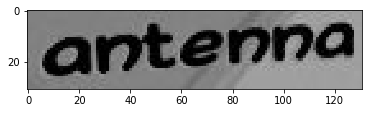

In [31]:
train_dataset_path = '/tf/ocr_credit_card/dataset/synth90dataset/train'
val_dataset_path = '/tf/ocr_credit_card/dataset/synth90dataset/val'

img_paths, labels = parse_mjsynth(train_dataset_path)


def find_max_length(labels):
    lengths = []
    for label in labels:
        length = len(label)
        lengths.append(length)
    print(max(lengths))
    return


find_max_length(labels)

im = cv2.imread(img_paths[0])

plt.figure()
plt.imshow(im)
plt.show()


# Prepare table lookup and find max length for the data !!


## Unit Test

In [35]:
import time
    
config = {
    'annotation_path': val_dataset_path, 
    'table_path': TABLE_PATH, 
    'img_width': 128, 
    'img_heigth': 32, 
    'batch_size': 1
}

def get_dataloader(config):
    return OCRDataLoader(
        config['annotation_path'], 
        config['img_heigth'], 
        config['img_width'], 
        config['table_path'], 
        shuffle=False, 
        batch_size=config['batch_size'])

    
def convert_label_test(config):
    with open(config['table_path'], 'r') as f:
        char_mapper = [char.strip() for char in f]
    
    dataloader = get_dataloader(config)
    img_paths = dataloader.img_paths
    labels = dataloader.labels
    
    for idx, (x, y) in enumerate(dataloader()):
        dense = tf.sparse.to_dense(y).numpy()[0]
        text = ''

        for char_index in dense:
            text += char_mapper[char_index]
        assert text == labels[idx]
        

def timeit(ds, steps):
    overall_start = time.perf_counter()
    it = iter(ds.take(steps + 1))
    next(it)

    start = time.perf_counter()
    for i, (images, labels) in enumerate(it):
        if i % 10 == 0:
            print('.', end='')
    
    end = time.perf_counter()

    duration = end - start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(64 * steps / duration))
    print("Total time: {}s".format(end - overall_start))


if __name__ == "__main__":
    timeit(get_dataloader(config)(), 64)
    print('Start unit test')
    convert_label_test(config)
    print('Finish unit testing')


.......64 batches: 0.03490217821672559 s
117356.57226 Images/s
Total time: 0.06083580385893583s
Start unit test
Finish unit testing


## C-RNN Model

In [7]:
# Architecture Parameter
IMAGE_SIZE = (132, 32)
NUM_CLASSES = 11

# Training Parameter
BATCH_SIZE = 12
LEARNING_RATE = 0.01
BLANK_INDEX = -1
EPOCHS = 150

# Artifact Parameter
SAVE_FREQUENCY = 20 # Every epochs
CHECKPOINT_DIR = '/tf/ocr_credit_card/artifact/model'
# 64, 128, 256, 256, 512, 512, 512


# # Architecture Parameter
# IMAGE_SIZE = (100, 32)
# NUM_CLASSES = 63

# # Training Parameter
# BATCH_SIZE = 64
# LEARNING_RATE = 0.01
# BLANK_INDEX = -1
# EPOCHS = 15

# # Artifact Parameter
# SAVE_FREQUENCY = 20 # Every epochs
# CHECKPOINT_DIR = '/tf/ocr_credit_card/artifact/model_clone'
# 32, 32, 32, 32, 64, 64, 64

In [8]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Reshape, Lambda, BatchNormalization
from tensorflow.keras.layers import add, concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow import losses


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_model(training):
    input_shape = (IMAGE_SIZE[1], IMAGE_SIZE[0], 1)     # (128, 64, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32')  

    # Convolution layer (VGG)
    conv1 = Conv2D(64, kernel_size=3, padding='same', name='conv1', kernel_initializer='truncated_normal')(inputs)  
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max1')(conv1)  

    conv2 = Conv2D(128, kernel_size=3, padding='same', name='conv2', kernel_initializer='truncated_normal')(pool1)  
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max2')(conv2)  

    conv3 = Conv2D(256, kernel_size=3, padding='same', name='conv3', kernel_initializer='truncated_normal')(pool2)  
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Conv2D(256, kernel_size=3, padding='same', name='conv4', kernel_initializer='truncated_normal')(conv3)  
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), name='max3')(conv4)  

    conv5 = Conv2D(512, kernel_size=3, padding='same', name='conv5', kernel_initializer='truncated_normal')(pool4)  
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Conv2D(512, kernel_size=3, padding='same', name='conv6')(conv5)  
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), name='max4')(conv6)  

    conv7 = Conv2D(512, kernel_size=2, strides=(2, 1), padding='same', kernel_initializer='truncated_normal', name='con7')(pool6)  
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    
    # Map to sequence
    inner = tf.squeeze(input=conv7, axis=1, name='map_to_sequence')

    # RNN layer
    lstm_1 = Bidirectional(LSTM(units=256, dropout=0.5, return_sequences=True))(inner)
    lstm_1 = BatchNormalization()(lstm_1)
    lstm_2 = Bidirectional(LSTM(units=256, dropout=0.5, return_sequences=True))(lstm_1)
    lstm_2 = BatchNormalization()(lstm_2)

    # transforms RNN output to character activations:
    logits = Dense(NUM_CLASSES, kernel_initializer='truncated_normal',name='dense2')(lstm_2)
    
    # Softmax activation might not needed
#     y_pred = Activation('softmax', name='softmax')(inner)
    
    # Swap batch and width sequence axis
    rnn_out = tf.transpose(logits, [1, 0, 2], name='transpose_time_major') # [width, batch, n_classes]

    return Model(inputs=inputs, outputs=logits, name='CRNN')


In [12]:
get_model(training=False).summary()

Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 32, 100, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 100, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 100, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 32, 100, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 16, 50, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 50, 32)        128    

## Train Model

In [23]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


def load_images(imgs_path, img_size=(128, 32)):
    images = []
    for i in range(len(imgs_path)):
        im = load_img(imgs_path[i])
        im = img_to_array(im)
        im = cv2.resize(im, img_size)
        im = im[:, :, 1]
        images.append(im / 255)
    images = np.array(images)
    images = np.expand_dims(images, axis=3)
    return images


def read_img_paths_and_labels(annotation_path):
    img_paths = []
    labels = []

    annotation_folder = os.path.dirname(annotation_path)
    with open(annotation_path) as f:
        content = np.array(
            [line.strip().split() for line in f.readlines()])

    part_img_paths = content[:, 0]    
    part_labels = content[:, 1]
    part_img_paths = [os.path.join(annotation_folder, line)
                      for line in part_img_paths]
    img_paths.extend(part_img_paths)
    labels.extend(part_labels)

    return img_paths, labels


def truncate_label(text, maxTextLen):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    cost = 0
    for i in range(len(text)):
        if i != 0 and text[i] == text[i-1]:
            cost += 2
        else:
            cost += 1
        if cost > maxTextLen:
            return text[:i]
    return text


def to_sparse(texts):
    "put ground truth texts into sparse tensor for ctc_loss"
    indices = []
    values = []
    shape = [len(texts), 0] # last entry must be max(labelList[i])

    # go over all texts
    for (batch_element, text) in enumerate(texts):
        # convert to string of label (i.e. class-ids)
        labelStr = [charlist.index(c) for c in text]
        # sparse tensor must have size of max. label-string
        if len(labelStr) > shape[1]:
            shape[1] = len(labelStr)
        # put each label into sparse tensor
        for (i, label) in enumerate(labelStr):
            indices.append([batch_element, i])
            values.append(label)

    return (indices, values, shape)


if __name__ == "__main__":
    max_text_len = 16
    charlist = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    imgs_path, labels = read_img_paths_and_labels(TRAIN_ANNOTATION_PATH)
    
    model = get_model(training=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)

    images = load_images(imgs_path)
    output = model(images[:12], training=False)
    output_length = tf.fill([tf.shape(output)[0]], tf.shape(output)[1])
    indices, values, shape = to_sparse(labels[:12])
    sparse_label = tf.sparse.SparseTensor(indices, values, shape)
    
    dataloader = OCRDataLoader(
        TRAIN_ANNOTATION_PATH, 
        IMAGE_SIZE[1], 
        IMAGE_SIZE[0], 
        TABLE_PATH, 
        shuffle=True, 
        batch_size=BATCH_SIZE)
    
    for x, y in dataloader():
        with tf.GradientTape() as g:
            output = model(images[:12], training=True)
            output_length = tf.fill([tf.shape(output)[0]], tf.shape(output)[1])
            loss = tf.nn.ctc_loss(
                labels=sparse_label,
                logits=output,
                label_length=None,
                logit_length=output_length,
                logits_time_major=False,
                blank_index=-1)
            loss = tf.reduce_mean(loss)
            print(loss)
            grads = g.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
    

tf.Tensor(79.17115, shape=(), dtype=float32)
tf.Tensor(77.892334, shape=(), dtype=float32)
tf.Tensor(172.2171, shape=(), dtype=float32)
tf.Tensor(236.6845, shape=(), dtype=float32)
tf.Tensor(443.34763, shape=(), dtype=float32)
tf.Tensor(265.72012, shape=(), dtype=float32)
tf.Tensor(373.3518, shape=(), dtype=float32)
tf.Tensor(233.28297, shape=(), dtype=float32)
tf.Tensor(213.11852, shape=(), dtype=float32)
tf.Tensor(209.57448, shape=(), dtype=float32)
tf.Tensor(296.1229, shape=(), dtype=float32)
tf.Tensor(380.9552, shape=(), dtype=float32)
tf.Tensor(209.5179, shape=(), dtype=float32)
tf.Tensor(85.03777, shape=(), dtype=float32)
tf.Tensor(138.94128, shape=(), dtype=float32)
tf.Tensor(132.69215, shape=(), dtype=float32)
tf.Tensor(95.04443, shape=(), dtype=float32)
tf.Tensor(98.08866, shape=(), dtype=float32)
tf.Tensor(66.30195, shape=(), dtype=float32)
tf.Tensor(40.25712, shape=(), dtype=float32)
tf.Tensor(39.590717, shape=(), dtype=float32)
tf.Tensor(29.179571, shape=(), dtype=float32)


In [19]:
def dataloader(shuffle, train_path=train_dataset_path, val_path=val_dataset_path):
    train_dl = OCRDataLoader(
        train_path, 
        IMAGE_SIZE[1], 
        IMAGE_SIZE[0], 
        TABLE_PATH, 
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
    print(f"Num of training samples: {len(train_dl)}")
    val_dl = OCRDataLoader(
        val_path, 
        IMAGE_SIZE[1], 
        IMAGE_SIZE[0], 
        TABLE_PATH, 
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
    print(f"Num of validation samples: {len(val_dl)}")
    return train_dl, val_dl


@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as g:
        # trainable=True is default,  are automatically watched.
        # g.watch(x)
        logits = model(x, training=True)
        logit_length = tf.fill([tf.shape(logits)[0]], tf.shape(logits)[1])
        loss = tf.nn.ctc_loss(
            labels=y,
            logits=logits,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=False,
            blank_index=BLANK_INDEX)
        loss = tf.reduce_mean(loss)
    grads = g.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


def train(model, optimizer, dataset, log_freq=1000):
    train_loss = tf.keras.metrics.Mean(name="loss", dtype=tf.float32)
    for x, y in dataset:
        loss = train_one_step(model, optimizer, x, y)
        train_loss.update_state(loss)
        if tf.equal(optimizer.iterations % log_freq, 0):
            print(f'Train loss on {optimizer.iterations.numpy()} is {train_loss.result().numpy()}')
            tf.summary.scalar('loss', train_loss.result(),
                              step=optimizer.iterations)
            train_loss.reset_states()
    

@tf.function
def val_one_step(model, x, y):
    logits = model(x, training=False)
    logit_length = tf.fill([tf.shape(logits)[0]], tf.shape(logits)[1])
    loss = tf.nn.ctc_loss(
        labels=y,
        logits=logits,
        label_length=None,
        logit_length=logit_length,
        logits_time_major=False,
        blank_index=BLANK_INDEX)
    loss = tf.reduce_mean(loss)
    decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(
        inputs=tf.transpose(logits, perm=[1, 0, 2]),
        sequence_length=logit_length,
        merge_repeated=True)
    return loss, decoded


def val(model, dataset, step, num_samples):
    val_loss = tf.keras.metrics.Mean(name="loss", dtype=tf.float32)
    num_correct_samples = 0
    for x, y in dataset:
        loss, decoded = val_one_step(model, x, y)
        cnt = map_and_count(decoded, y, get_char_mapper(TABLE_PATH))
        val_loss.update_state(loss)
        num_correct_samples += cnt
    tf.summary.scalar("loss", val_loss.result(), step=step)
    accuracy = num_correct_samples / num_samples * 100
    print(accuracy)
    tf.summary.scalar("accuracy", accuracy, step=step)
    val_loss.reset_states()


if __name__ == "__main__":
    train_dl, val_dl = dataloader(shuffle=True)
    localtime = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    print(f"Start at {localtime}")
    
    model = get_model(training=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
    
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=2)
    
    for epoch in range(1, EPOCHS+1):
        train(model, optimizer, train_dl())
        
        if not (epoch-1) % SAVE_FREQUENCY:
            checkpoint_path = manager.save(optimizer.iterations)
            print("Model saved to {}".format(checkpoint_path))
        
        if val_dl is not None and epoch > 10:
            val(model, val_dl(), optimizer.iterations, len(val_dl))
        print(f'Finish training on epoch {epoch}')


In [103]:
# if __name__ == "__main__":
    
#     train_dl, val_dl = dataloader()
#     localtime = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
#     print(f"Start at {localtime}")
    
#     model = get_model(training=True)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
#     train_summary = tf.summary.create_file_writer(
#         f"artifact/logs/{localtime}/train")
#     val_summary = tf.summary.create_file_writer(
#         f"artifact/logs/{localtime}/val")
    
#     for epoch in range(EPOCHS):
# #         with train_summary.as_default():
#         train(model, optimizer, train_dl())
#         if val_dl is not None:
#             print(val_dl)
# #             with val_summary.as_default():
#             val(model, val_dl(), optimizer.iterations, len(val_dl))
#         print(f'Finish training on epoch {epoch}')

## Evaluate Model

In [10]:
def load_model_checkpoint(model, optimizer, checkpoint_dir):
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    if tf.train.latest_checkpoint(checkpoint_dir):
        print("Restored from {}".format(
            tf.train.latest_checkpoint(checkpoint_dir)))
    else:
        print("Initializing fail, check checkpoint")
        sys.exit()

model = get_model(training=False)
model.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
load_model_checkpoint(model, optimizer, CHECKPOINT_DIR)


Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 32, 132, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 132, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 132, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 32, 132, 64)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 16, 66, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 66, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 66, 128)       512    

In [11]:
def sequence_error_count(model, batch_size, seq_length):
    errors = []

    for idx, (x, y) in enumerate(val_dl()):

#         batch_size = 12
#         seq_length = 32

        f_result = np.zeros(shape=(batch_size, seq_length))

        preds = model(x, training=False)
        preds_length = tf.fill([tf.shape(preds)[0]], tf.shape(preds)[1])

        decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(preds, perm=[1, 0, 2]),
            sequence_length=preds_length,
            merge_repeated=True)
        
        
#         decoded, neg_sum_logits = tf.nn.ctc_beam_search_decoder(
#             inputs=tf.transpose(preds,perm=[1, 0, 2]),
#             sequence_length=preds_length,
#             beam_width=200)
        

        decoded = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
        decoded = map_to_chars(decoded, get_char_mapper(TABLE_PATH), blank_index=-1, 
                               merge_repeated=False)
#         print(decoded)

        decoded_y = tf.sparse.to_dense(y, default_value=-1).numpy()
        decoded_y = map_to_chars(decoded_y, get_char_mapper(TABLE_PATH), blank_index=-1, 
                               merge_repeated=False)
        
#         print(decoded_y)

        pred_length = [len(y) for y in decoded]
        y_length = [len(y) for y in decoded_y]
        
        for i in range(len(decoded)):
            pred = decoded[i]
            y_gt = decoded_y[i]

            pred_vec = np.array(['' for _ in range(seq_length)])
            y_vec = np.array(['' for _ in range(seq_length)])

            pred_vec[:pred_length[i]] = np.array([pred[i] for i in range(len(pred))])
            y_vec[:y_length[i]] = np.array([y_gt[i] for i in range(len(y_gt))])

            vfunc = np.vectorize(lambda x: 1 if x == 1 else 0)
            comparison = (pred_vec == y_vec) + 1
            comparison = vfunc(comparison)

            f_result[i] = comparison
            
        errors.append(f_result)
        
    return errors


def sum_of_error(model, batch_size, seq_length, dataset_size):
    errors = sequence_error_count(model, batch_size, seq_length)
    result = np.reshape(np.array(errors), (-1, seq_length))
    result = result[:dataset_size]
    return np.sum(result, axis=0)


Num of training samples: 274594
Num of validation samples: 31908


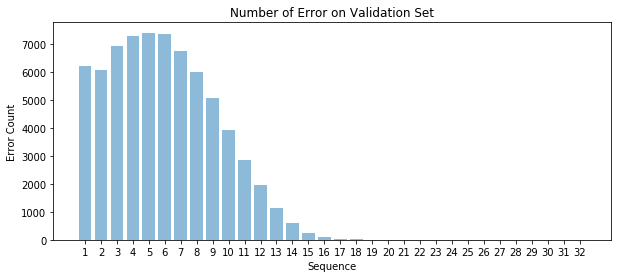

In [16]:
def dataloader(shuffle, train_path=train_dataset_path, val_path=val_dataset_path):
    train_dl = OCRDataLoader(
        train_path, 
        IMAGE_SIZE[1], 
        IMAGE_SIZE[0], 
        TABLE_PATH, 
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
    print(f"Num of training samples: {len(train_dl)}")
    val_dl = OCRDataLoader(
        val_path, 
        IMAGE_SIZE[1], 
        IMAGE_SIZE[0], 
        TABLE_PATH, 
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
    print(f"Num of validation samples: {len(val_dl)}")
    return train_dl, val_dl


train_dl, val_dl = dataloader(shuffle=False, train_path=train_dataset_path, val_path= val_dataset_path)

# Edit this line
sequences = np.arange(1, 33, 1).tolist()
sequence_error = sum_of_error(model, batch_size=64, seq_length=32, dataset_size=val_dl.size)

plt.figure(figsize=(10, 4))
plt.bar(sequences, sequence_error, align='center', alpha=0.5)
plt.xticks(sequences, sequences)
plt.ylabel('Error Count')
plt.xlabel('Sequence')
plt.title('Number of Error on Validation Set')
plt.show()

Num of training samples: 570
Num of validation samples: 100


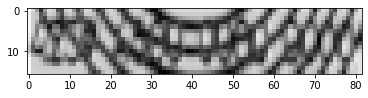

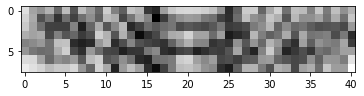

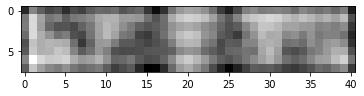

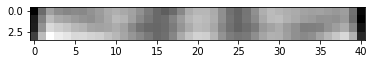

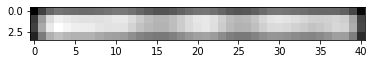

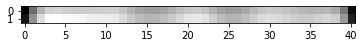

In [25]:
# Unboxing CTC loss


def normalize_mstd(img_path):
    image_path = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_path, channels=1)
    image = tf.image.resize(image, [32, 164])
    std = tf.math.reduce_std(image)
    mean = tf.math.reduce_mean(image)
    image = tf.divide(tf.subtract(image, mean), std)
    return image


def normalize_half_val(img_path):
    image_path = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_path, channels=1)
    image = tf.image.resize(image, [32, 164])
    image = tf.subtract(tf.divide(image, 127.5), 1.0)
    return image


def normalize_scale(img_path):
    image_path = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_path, channels=1)
    image = tf.image.resize(image, [32, 164])
    image = ((image / 255) * 2) - 1
    return image


def get_model_activation(model, image, 
                     layer_names=['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6'], 
                     pool_sizes=[(2, 2), (2, 2), None, (2, 1), None, (2, 1)],
                     pool_strides=[(2,2), (2, 2), None, (2,1), None, (2, 1)]):
    activations = []
    out = image
    for idx, layer in enumerate(layer_names):
        conv = model.get_layer(name=layer)(out)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        if pool_sizes[idx] is not None:
            conv = MaxPooling2D(pool_size=pool_sizes[idx], strides=pool_strides[idx])(conv)
        out = conv
        activations.append(np.squeeze(np.average(out.numpy(), axis=3)))

    return activations


if __name__ == "__main__":
    train_dl, val_dl = dataloader(shuffle=False, train_path=TRAIN_ANNOTATION_PATH, val_path= VAL_ANNOTATION_PATH)
    
    img_paths = train_dl.img_paths
    im_1 = normalize_mstd(img_paths[10])
    im_2 = normalize_half_val(img_paths[30])
    im_3 = normalize_scale(img_paths[10])
    
#     plt.figure()
#     plt.imshow(np.squeeze(im_1.numpy()), cmap='gray')
#     plt.show()
    
#     plt.figure()
#     plt.imshow(np.squeeze(im_2.numpy()), cmap='gray')
#     plt.show()
    
#     plt.figure()
#     plt.imshow(np.squeeze(im_3.numpy()), cmap='gray')
#     plt.show()

    img = np.array([im_2])
    activations = get_model_activation(model, img)
                           
    for act in activations:
        plt.figure()
        plt.imshow(act, cmap='gray')
        plt.show()
                           
#     plt.figure()
#     plt.imshow(activation, cmap='gray')
#     plt.show()
    
    

In [45]:
tf.train.list_variables(tf.train.latest_checkpoint(CHECKPOINT_DIR))

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE', [64]),
 ('model/layer_with_weights-0/bias/.OPTIMIZER_SLOT/optimizer/momentum/.ATTRIBUTES/VARIABLE_VALUE',
  [64]),
 ('model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [3, 3, 1, 64]),
 ('model/layer_with_weights-0/kernel/.OPTIMIZER_SLOT/optimizer/momentum/.ATTRIBUTES/VARIABLE_VALUE',
  [3, 3, 1, 64]),
 ('model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE', [64]),
 ('model/layer_with_weights-1/beta/.OPTIMIZER_SLOT/optimizer/momentum/.ATTRIBUTES/VARIABLE_VALUE',
  [64]),
 ('model/layer_with_weights-1/gamma/.ATTRIBUTES/VARIABLE_VALUE', [64]),
 ('model/layer_with_weights-1/gamma/.OPTIMIZER_SLOT/optimizer/momentum/.ATTRIBUTES/VARIABLE_VALUE',
  [64]),
 ('model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE', [64]),
 ('model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
  [64]),
 ('model/layer_with_weights-10/bias/.ATTRIBUTES/VARIABLE_